<a href="https://colab.research.google.com/github/Chandramani05/Hunting-for-Exoplanet-in-Deep-Space/blob/main/MSML_63_SVM%2C_Random_Forest_and_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import warnings
warnings.filterwarnings("ignore")

In [166]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, cohen_kappa_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank2d, RadViz, Rank2D
from yellowbrick.classifier import DiscriminationThreshold, PrecisionRecallCurve, ROCAUC
from yellowbrick.model_selection import feature_importances, CVScores, RFECV, FeatureImportances
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix
from xgboost import XGBClassifier


In [167]:
df = pd.read_csv("/content/drive/MyDrive/Kepler Exoplanet/data/Cleaned Kepler Data.csv")
df.drop(columns = ["Unnamed: 0"], inplace=True)
print(df.shape)
df.head()

(9199, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


##Getting the Columns without error

We eliminate all the columns that are either of the following

1. Assigned after other values are measured from readings
2. Contain ID or name attributes


In [168]:
all_columns = df.columns
errors = [col for col in all_columns if "err" in col]
exclude = ["rowid", "kepid", "kepoi_name", "koi_score", "koi_disposition", "koi_pdisposition", 
           "koi_tce_delivname", "koi_tce_plnt_num"] + errors
usable = list(set(all_columns) - set(exclude))

In [169]:
print(f"Columns being analysed: {len(usable)}")
df[usable].head()

Columns being analysed: 19


,koi_impact,koi_steff,koi_fpflag_nt,koi_insol,koi_kepmag,koi_srad,koi_prad,koi_duration,koi_fpflag_ec,dec,koi_depth,koi_model_snr,ra,koi_time0bk,koi_teq,koi_period,koi_slogg,koi_fpflag_ss,koi_fpflag_co
0,0.146,5455.0,0,93.59,15.347,0.927,2.26,2.95750,0,48.141651,615.8,35.8,291.93423,170.538750,793.0,9.488036,4.467,0,0
1,0.586,5455.0,0,9.11,15.347,0.927,2.83,4.50700,0,48.141651,874.8,25.8,291.93423,162.513840,443.0,54.418383,4.467,0,0
2,0.969,5853.0,0,39.30,15.436,0.868,14.60,1.78220,0,48.134129,10829.0,76.3,297.00482,175.850252,638.0,19.899140,4.544,1,0
3,1.276,5805.0,0,891.96,15.597,0.791,33.46,2.40641,0,48.285210,8079.2,505.6,285.53461,170.307565,1395.0,1.736952,4.564,1,0
4,0.701,6031.0,0,926.16,15.509,1.046,2.75,1.65450,0,48.226200,603.3,40.9,288.75488,171.595550,1406.0,2.525592,4.438,0,0


## Extracting Dataframe Subset
We extract only those rows which are either positive or negative examples i.e. the `disposition` value is *not* `CANDIDATE`. This is because `CANDIDATE` is the default value for all obects of interest picked up by Kepler. The labels `CONFIRMED` and FALSE `POSITIVE` serve as our positive and negative labels

**Difference between disposition and pdisposition?**
We can use either of the two columns as our target variable, since both of them contain the target labels we desire. While pdisposition gives us the most probable labels based on the physical explanation given by the readings, disposition values are based on the NASA Exoplanet Archive Data.

In [170]:
np.unique(df["koi_disposition"].values)
subset_df = df[df["koi_disposition"] != "CANDIDATE"]
print(subset_df.shape)
subset_df.head()

(7014, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [171]:
X = subset_df[usable].values
y = subset_df["koi_disposition"].apply(lambda x: x=='CONFIRMED').astype(int).values

In [172]:
subset_df["koi_disposition"].value_counts()

FALSE POSITIVE    4722
CONFIRMED         2292
Name: koi_disposition, dtype: int64

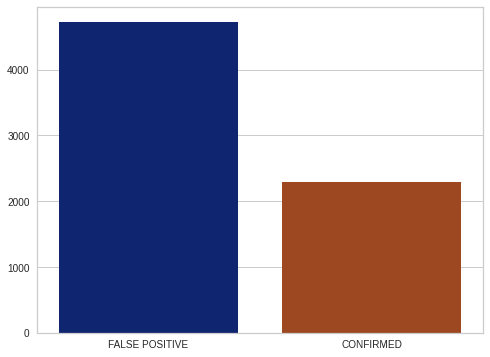

In [173]:
fig, ax = plt.subplots(figsize = (8,6))
with sns.color_palette("dark", 3):
        sns.barplot(subset_df['koi_disposition'].value_counts().index, subset_df['koi_disposition'].value_counts().values)
     


#Data Visualiazation

In [174]:
def getVisualisationPCA(X, y):
    x = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(x)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    plt.figure(figsize=(12,8))
    pca_df["TARGET"] = y
    labels = np.unique(y)
    labels = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in labels]
    pca_df["TARGET"] = ["CONFIRMED" if i ==1 else "FALSE POSITIVE" for i in pca_df["TARGET"].values]
    plt.grid()
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()
    plt.savefig("pca.png", dpi=600)
    
def getVarianceContribution(X, y):
    cols = X.shape[1]
    x = StandardScaler().fit_transform(X)
    pca = PCA().fit(x)
    variance = pca.explained_variance_ratio_
    s = np.sum(variance)
    p = variance/s
    plt.grid()
    plt.bar(list(range(1, cols+1)), p)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.savefig("variance.png", dpi=600)
    plt.show()
    
    
def getFeatureCorrelation(X, y):
    visualizer = FeatureCorrelation(labels=usable)
    visualizer.fit(X, y)
    visualizer.show("correlation.png", dpi=600)
    
    
def getPearsonRanking(X):
    visualizer = rank2d(X, features=usable)
    visualizer = Rank2D(algorithm='pearson', features=usable)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show(outpath="pearson_ranking.png", dpi=600)
    

def getRadialViz(X, y):
    visualizer = RadViz(classes=[0, 1], features = usable)
    visualizer.fit(X, y)           
    visualizer.transform(X)        
    visualizer.show("radial.png", dpi=600)

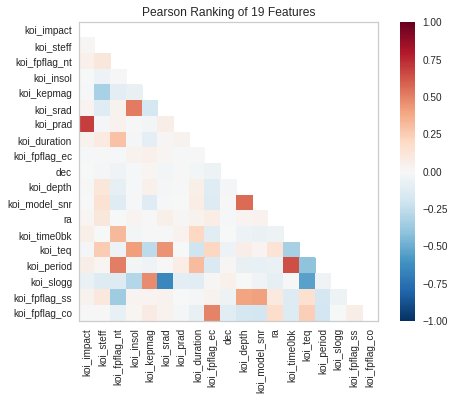

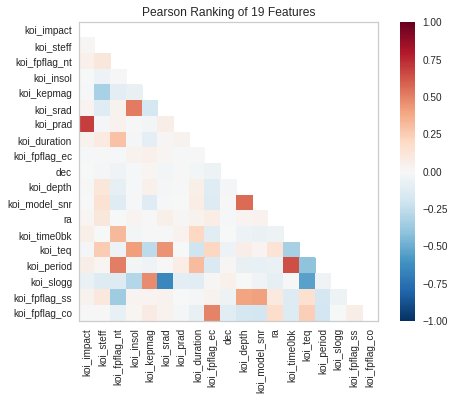

In [175]:
getPearsonRanking(X)

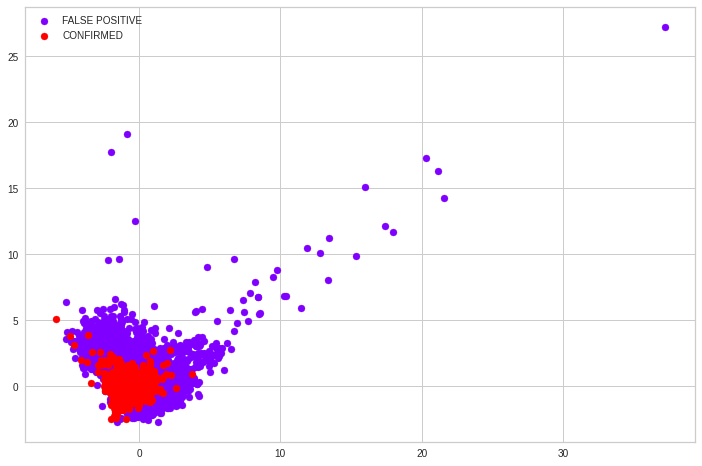

In [176]:
getVisualisationPCA(X, y)

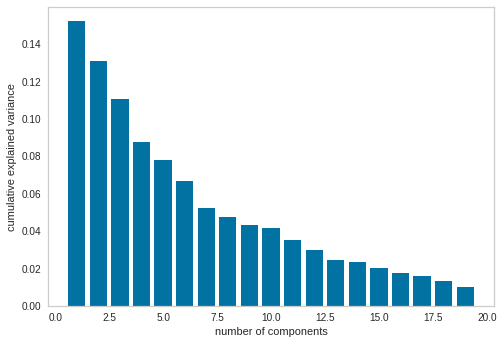

In [177]:
getVarianceContribution(X, y)

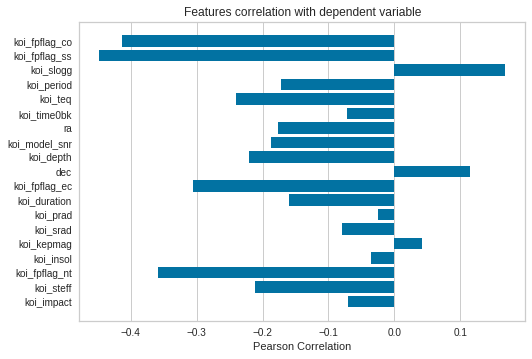

In [178]:
getFeatureCorrelation(X, y)

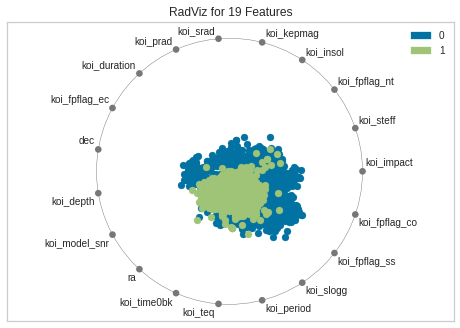

In [179]:
getRadialViz(X, y)



*   We can see that our columns are not interdependent and we can use all our columns
*   We observe that the two classes are not linearly separable, hence a simple Logistic Regression classifier will not do well.


*   Most important, we see there is a class imbalance present, hence we cannot go on accuracy scores and will need to compare scores for prediction across both classes - F1 scores and balanced accuracy scores

We need to hence using different techniques of non-linear classification, which can handle the non-linearity issue as well as class imbalance. We can employ Bagging or Boosting Techniques such as


*  SVM
*  Random Forests
* XgBoost







In [180]:
X = StandardScaler().fit_transform(X)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [182]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5611, 19), (1403, 19), (5611,), (1403,))

Evaluation Metric
Since the dataset is imbalanced, we cannot use accuracy, hence we opt for the following -

1. Confusion Matrix
2. F1 Score
3. Balanced Accuracy Score

In [183]:
def performance(test, pred):
    conf_matrix = confusion_matrix(test, pred)
    f1 = f1_score(test, pred)
    report = classification_report(test, pred)
    accuracy = balanced_accuracy_score(test, pred)
    print(f"F1 Score: {f1}")
    print(f"Accuracy Score: {accuracy}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(report)

##CV Score

In [184]:
def crossValidationCheck(classifier, X, y, K=10):

    cv = KFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    visualizer.show(f"{str(classifier)[:5]}_cv.png", dpi=600)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)
    
    cv = StratifiedKFold(n_splits=K, random_state=1, shuffle=True)
    scores = cross_val_score(classifier, X, y, scoring='f1', cv=cv, n_jobs=-1)
    print(f"Average F1 score over Stratified {K}-Folds: {scores.mean()}")
    
    visualizer = CVScores(classifier, cv=cv, scoring='f1')
    visualizer.fit(X, y)
    
    visualizer = LearningCurve(classifier, cv=cv, scoring='f1', n_jobs=-1)
    visualizer.fit(X, y)

##Feature Importance

In [185]:
def getFeatureImportance(model, X, y):
    viz = FeatureImportances(model, labels=usable)
    viz.fit(X, y)
    viz.show(f"{model}_imp.png", dpi=600)

##Class Predictions

In [186]:
def getClassPredictionError(classifier):
    visualizer = ClassPredictionError(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def getClassificationReport(classifier):
    visualizer = ClassificationReport(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def getDiscriminationThreshold(classifier):
    visualizer = DiscriminationThreshold(classifier, exclude=["queue_rate"])
    visualizer.fit(X, y)        
    
def getPrecisionRecall(classifier):
    visualizer = PrecisionRecallCurve(classifier)
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    
def rocCurve(classifier):
    visualizer = ROCAUC(classifier, classes=[0, 1])
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)

In [187]:
import os
import seaborn as sns

In [188]:
def plot_confusion_matrix(predictions, model):
  cm = confusion_matrix(predictions, y_test)
  ax = plt.figure(figsize=(12,8))
  path = '/content/drive/MyDrive/Kepler Exoplanet'
  title = "Confusion Matrix For "  + model + '.png'
  titleCM = "Confusion Matrix For "  + model
  pathmain = os.path.join(path, title)
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in
                  cm.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in
                      cm.flatten()/np.sum(cm)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  ax = sns.heatmap(cm ,annot = labels, fmt = '',cmap = 'Blues')
  ax.set_title(titleCM, fontdict = {'weight' : 'bold', 'size' : '16'})
  # classification report
  ax.figure.savefig(pathmain)

In [189]:
def saveModel(model, filename):
    joblib.dump(model, filename)

def loadModel(filename):
    model = joblib.load(filename)
    return model

#SVM with Hyperparamter

In [190]:
parameters = {
    "C":np.arange(1, 3.05, 0.05),
    "gamma":["scale", "auto"],
    "shrinking":[True, False],
    "tol":[1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3],
    "class_weight":[None, "balanced"]
}

scores = ["f1", "balanced_accuracy"]

In [191]:
classifier = GridSearchCV(
    SVC(kernel="rbf", random_state=0),
    parameters,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier.fit(X_train, y_train)

Fitting 5 folds for each of 2296 candidates, totalling 11480 fits


GridSearchCV(estimator=SVC(random_state=0), n_jobs=-1,
             param_grid={'C': array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  ]),
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto'], 'shrinking': [True, False],
                         'tol': [0.001, 0.01, 0.1, 1, 10.0, 100.0, 1000.0]},
             refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [192]:
classifier.best_score_

0.9767271961928328

In [193]:
classifier.best_params_

{'C': 1.1500000000000001,
 'class_weight': None,
 'gamma': 'scale',
 'shrinking': True,
 'tol': 1}

In [194]:
performance(y_test, classifier.best_estimator_.predict(X_test))

F1 Score: 0.9824561403508771
Accuracy Score: 0.9859083662577113
Confusion Matrix:
[[939   6]
 [ 10 448]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.99      0.98      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



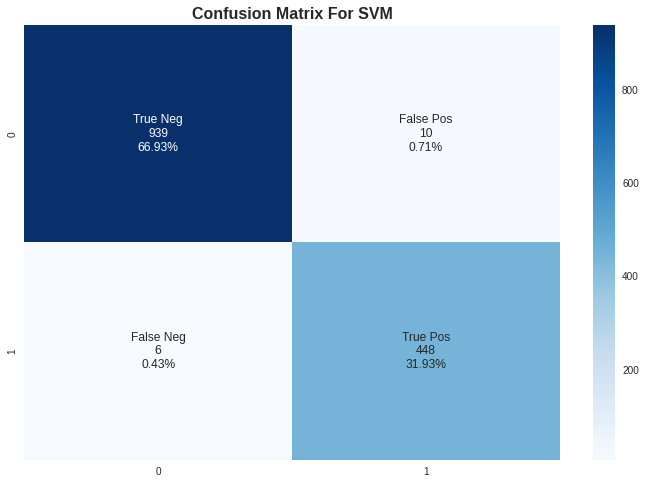

In [195]:
plot_confusion_matrix(classifier.best_estimator_.predict(X_test), "SVM")

Average F1 score over 10-Folds: 0.9774672635843935
Average F1 score over Stratified 10-Folds: 0.9774333163539165


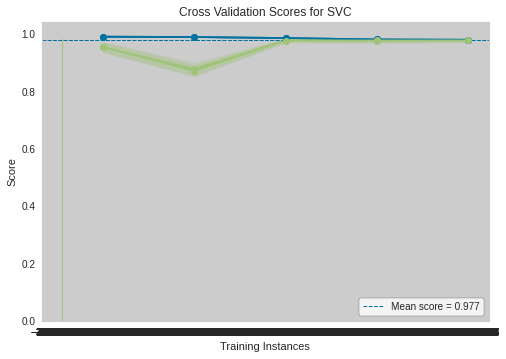

In [196]:
crossValidationCheck(classifier.best_estimator_, X, y, K=10)

In [197]:
saveModel(classifier.best_estimator_, "/content/drive/MyDrive/Kepler Exoplanet/model/svm-error.model")

#Random Forest

In [198]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
parameters = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}   

scores = ["f1", "balanced_accuracy"]

In [199]:
# with GridSearch
gs_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), parameters, scoring=scores, cv=5,  refit="f1",
    verbose=1,
    n_jobs=-1)

# We train the model
gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [200]:
gs_rf.best_score_

0.9803481992370099

In [201]:
gs_rf.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

Average F1 score over 10-Folds: 0.9800422120925989
Average F1 score over Stratified 10-Folds: 0.9807275367265855


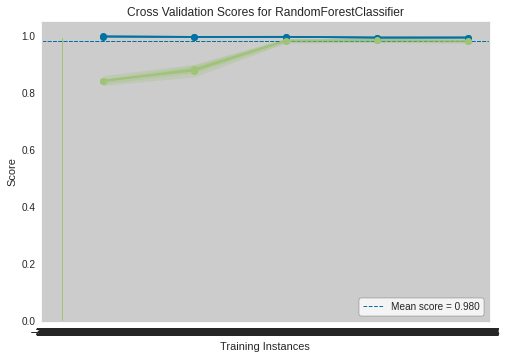

In [202]:
crossValidationCheck(gs_rf.best_estimator_, X, y, K=10)

###Feature Importance

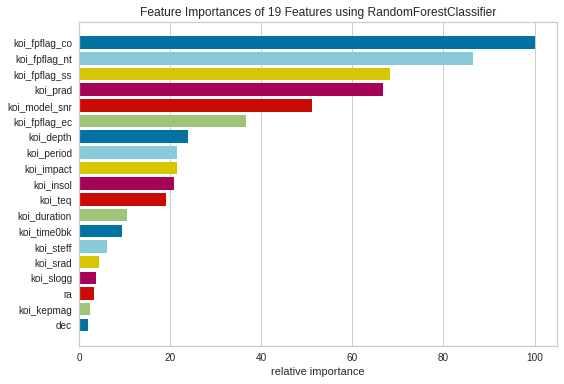

In [203]:
getFeatureImportance(gs_rf.best_estimator_, X, y)

In [204]:
pred = gs_rf.best_estimator_.predict(X_test)

###Performance

In [205]:
performance(y_test, pred)

F1 Score: 0.9800443458980044
Accuracy Score: 0.981474550033502
Confusion Matrix:
[[943   2]
 [ 16 442]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       945
           1       1.00      0.97      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.98      0.99      1403
weighted avg       0.99      0.99      0.99      1403



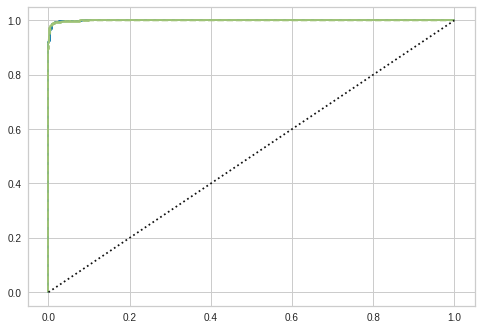

In [206]:
rocCurve(gs_rf.best_estimator_)

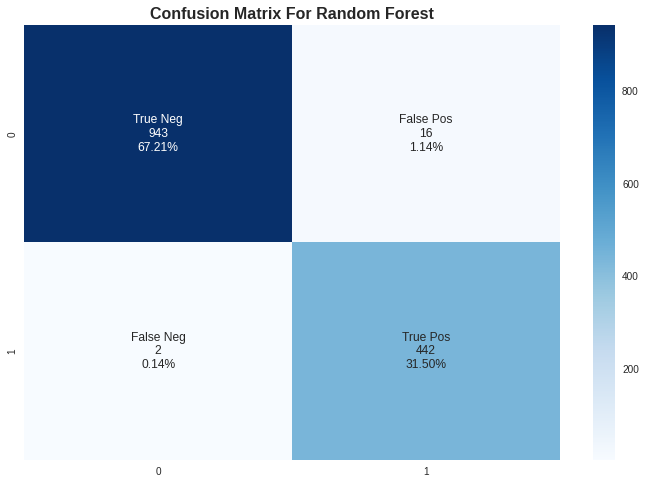

In [207]:
plot_confusion_matrix(pred, "Random Forest")

#XGBoost

In [208]:
parameters_xg = {
    "n_estimators":np.arange(50,150,10),
    "learning_rate":np.arange(0.5,1.5,0.05),
    "algorithm":["SAMME", "SAMME.R"],
    "base_estimator":[
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3),
        DecisionTreeClassifier(max_depth=None)
    ]
}

scores = ["f1", "balanced_accuracy"]

In [209]:
classifier_xg = RandomizedSearchCV(
    XGBClassifier(random_state=0),
    parameters_xg,
    scoring=scores,
    refit="f1",
    verbose=1,
    n_jobs=-1
)

classifier_xg.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'base_estimator': [DecisionTreeClassifier(max_depth=1),
                                                           DecisionTreeClassifier(max_depth=2),
                                                           DecisionTreeClassifier(max_depth=3),
                                                           DecisionTreeClassifier()],
                                        'learning_rate': array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ,
       1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45]),
                                        'n_estimators': array([ 50,  60,  70,  80,  90, 100, 110, 120, 130, 140])},
                   refit='f1', scoring=['f1', 'balanced_accuracy'], verbose=1)

In [210]:
classifier_xg.best_score_

0.9810674750471116

In [211]:
classifier_xg.best_params_

{'n_estimators': 60,
 'learning_rate': 0.6000000000000001,
 'base_estimator': DecisionTreeClassifier(max_depth=2),
 'algorithm': 'SAMME.R'}

Average F1 score over 10-Folds: 0.9794103661446574
Average F1 score over Stratified 10-Folds: 0.9811167911540153


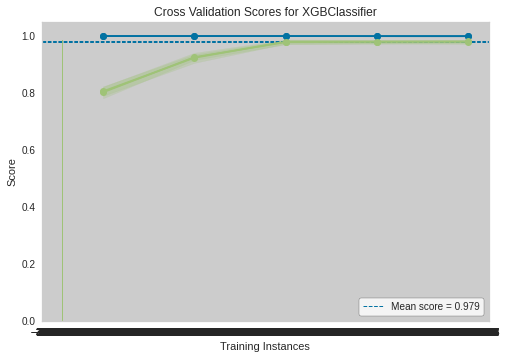

In [212]:
crossValidationCheck(classifier_xg.best_estimator_, X, y, K=10)

In [213]:
performance(y_test, classifier_xg.best_estimator_.predict(X_test))

F1 Score: 0.9836065573770492
Accuracy Score: 0.9875626718421477
Confusion Matrix:
[[938   7]
 [  8 450]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.98      0.98      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



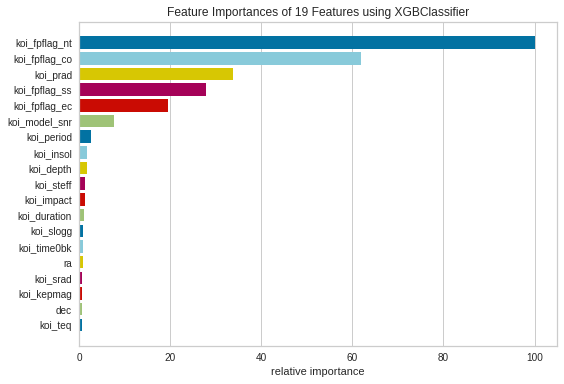

In [214]:
getFeatureImportance(classifier_xg.best_estimator_, X, y)

In [215]:
pred = classifier_xg.best_estimator_.predict(X_test)

In [216]:
performance(y_test, pred)

F1 Score: 0.9836065573770492
Accuracy Score: 0.9875626718421477
Confusion Matrix:
[[938   7]
 [  8 450]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       945
           1       0.98      0.98      0.98       458

    accuracy                           0.99      1403
   macro avg       0.99      0.99      0.99      1403
weighted avg       0.99      0.99      0.99      1403



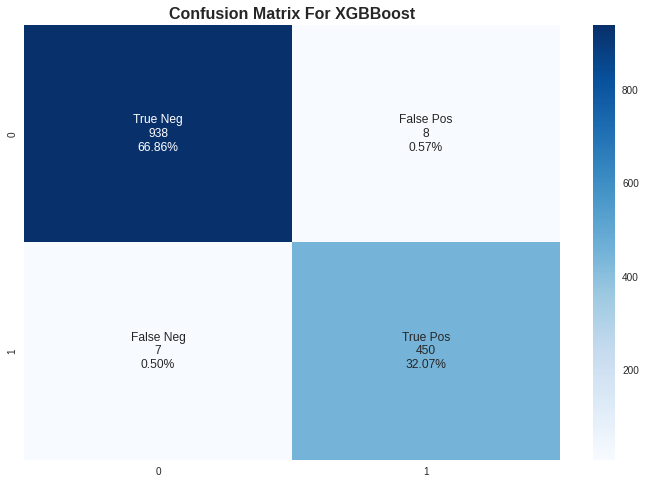

In [217]:
plot_confusion_matrix(pred, "XGBBoost")

In [218]:
saveModel(classifier.best_estimator_, "/content/drive/MyDrive/Kepler Exoplanet/model/XGboost-error.model")

# Cluster Analysis

In [219]:
from sklearn.cluster import KMeans, Birch, AgglomerativeClustering, DBSCAN, SpectralClustering
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance, SilhouetteVisualizer

## Extracting Dataframe Subset
We extract only those rows which are CONFIRMED examples i.e. the disposition value is CONFIRMED.

In [220]:
new_df = df[df["koi_disposition"] == "CONFIRMED"]
print(new_df.shape)
new_df.head()

(2292, 47)


,rowid,kepid,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
4,5,10854555,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
5,6,10872983,K00756.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714
6,7,10872983,K00756.02,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-232.0,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [221]:
X_cluster = new_df[usable].values
y_cluster = new_df["koi_disposition"].values

In [222]:
X_scaler = StandardScaler()
X_scaler.fit(X_cluster)
X_scaled = X_scaler.transform(X_cluster)

pca = PCA(n_components=2)
pca.fit(X_scaled)
X_2d = pca.transform(X_scaled)

In [223]:
X_2d.shape

(2292, 2)

In [224]:
def elbowVisualiser(model, metric=None):
    if metric is None:
        visualizer = KElbowVisualizer(model, k=(4,12))
    else:
        visualizer = KElbowVisualizer(model, k=(4,12), metric=metric)
    visualizer.fit(X_cluster)
    visualizer.show(f"{model}_elbow.png", dpi=600)
    
    
def interclusterDistanceVisualisation(model):
    visualizer = InterclusterDistance(model)
    visualizer.fit(X_cluster)
    visualizer.show(f"{model}_inter_cluster_dist.png", dpi=600)
    

def silhouetteVisualisation(model):
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X_cluster)
    visualizer.show(f"{model}_ss.png", dpi=600)
    
    
def viewKMeansScatter(model):
    clust_labels = model.predict(X_cluster)
    temp_df = new_df[usable].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        plt.grid()
        #print(X_2d.shape)    
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.savefig(f"{model}_scatter.png", dpi=600)
    return temp_df.groupby("Class").median()
    
def viewAggScatter(model):
    clust_labels = model.fit_predict(X_cluster)
    temp_df = new_df[usable].copy()
    temp_df["Class"] = clust_labels
    unique_classes = list(range(model.n_clusters))
    print(temp_df.groupby("Class").median())
    plt.grid()
    for cls in unique_classes:
        sub_df = temp_df[temp_df["Class"] == cls]
        temp_X = sub_df[[col for col in temp_df.columns if col != "Class"]].values
        temp_X_2d = pca.transform(X_scaler.transform(temp_X))
        #print(X_2d.shape)    
        plt.grid()
        plt.scatter(temp_X_2d[:, 0], temp_X_2d[:, 1], label=cls)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.savefig(f"agg_scatter_{model}.png", dpi=600)
    plt.show()
    
def getVisualisationPCA(X, y):
    X = StandardScaler().fit_transform(X)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X)
    
    pca_df = pd.DataFrame(
        data = principal_components,
        columns = ['principal component 1', 'principal component 2']
    )
    
    pca_df["TARGET"] = y
    labels = np.unique(y)
    
    colors = cm.plasma(np.linspace(0, 1, len(labels)))
    plt.grid()
    for label, color in zip(labels, colors):
        indicesToKeep = pca_df['TARGET'] == label
        plt.scatter(
            pca_df.loc[indicesToKeep, 'principal component 1'],
            pca_df.loc[indicesToKeep, 'principal component 2'],
            c = color,
            label=label
        )
        
    plt.legend()
    plt.grid()            

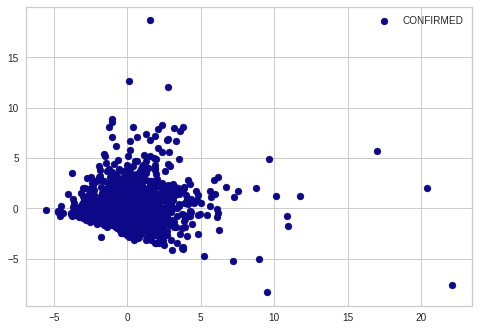

In [225]:
getVisualisationPCA(X_cluster, y_cluster)

##K-Means Clustering

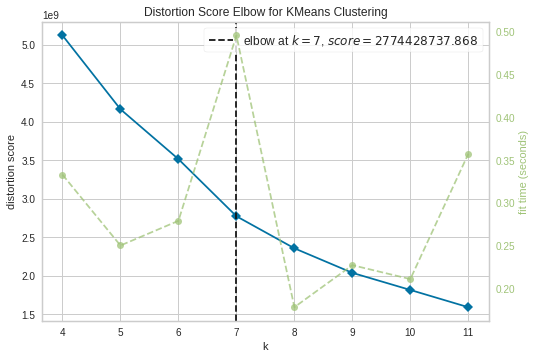

In [226]:
model = KMeans(random_state=0)
elbowVisualiser(model)

In [227]:
K=7
model = KMeans(K, max_iter=500, random_state=0)
model.fit(X_cluster)

KMeans(max_iter=500, n_clusters=7, random_state=0)

       koi_impact  koi_steff  koi_fpflag_nt  koi_insol  koi_kepmag  koi_srad  \
Class                                                                          
0          0.4055     4827.0            0.0     20.115     15.0925    0.7075   
1          0.3480     5561.0            0.0    257.290     14.9520    0.9470   
2          0.7250     7606.0            0.0  31099.550     11.7025    2.6675   
3          0.2695     5778.5            0.0     53.105     14.6735    1.0965   
4          0.2535     5742.0            0.0   2391.165     14.1155    1.2470   
5          0.2160     5510.0            0.0     67.300     15.1270    0.7930   
6          0.4125     5775.0            0.0    123.835     14.2735    1.0460   

       koi_prad  koi_duration  koi_fpflag_ec        dec  koi_depth  \
Class                                                                
0         2.220      2.957750            0.0  44.141949     965.50   
1        11.010      3.217900            0.0  45.439678   14231.00   

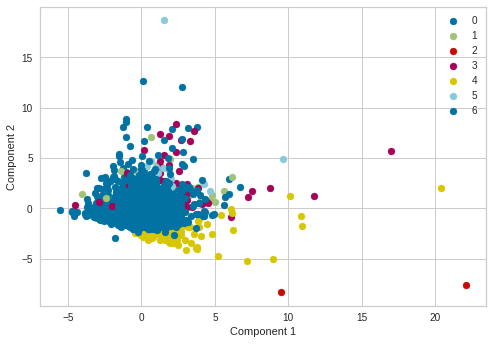

In [228]:
t=viewKMeansScatter(model)

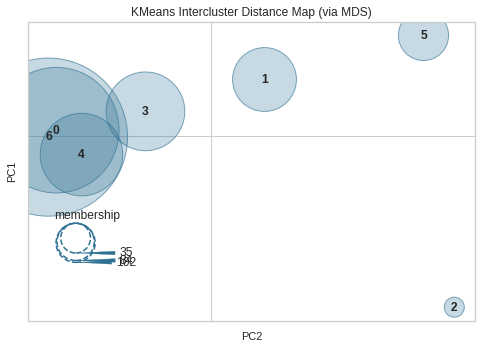

In [229]:
interclusterDistanceVisualisation(model)

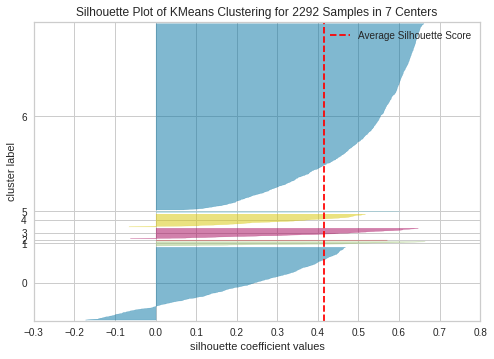

In [230]:
silhouetteVisualisation(model)

##Agglomerative Clustering

In [231]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [232]:
def plot_dendrogram(X):
    de = dendrogram(linkage(X, method='ward'))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.grid()
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")  
    plt.savefig("dendogram.png", dpi=600)

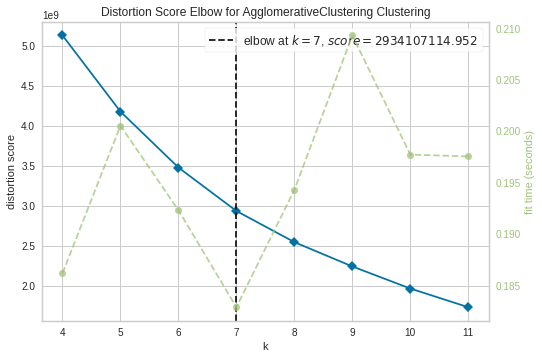

In [233]:
model = AgglomerativeClustering()
elbowVisualiser(model)

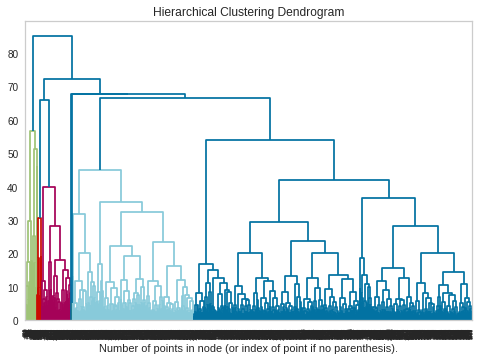

In [234]:
plot_dendrogram(X_scaled)

       koi_impact  koi_steff  koi_fpflag_nt  koi_insol  koi_kepmag  koi_srad  \
Class                                                                          
0           0.284     5758.0            0.0     82.730     14.6510    1.0810   
1           0.271     5718.0            0.0   2342.490     14.1130    1.2500   
2           0.421     5052.0            0.0     27.795     15.0305    0.7850   
3           0.725     7606.0            0.0  31099.550     11.7025    2.6675   
4           0.216     5510.0            0.0     67.300     15.1270    0.7930   
5           0.404     5850.0            0.0    154.340     14.1380    1.0935   
6           0.407     5532.0            0.0    252.220     15.0110    0.9000   

       koi_prad  koi_duration  koi_fpflag_ec        dec  koi_depth  \
Class                                                                
0          9.11      4.301000            0.0  43.680962    6674.70   
1          1.46      1.919000            0.0  44.292549     150.20   

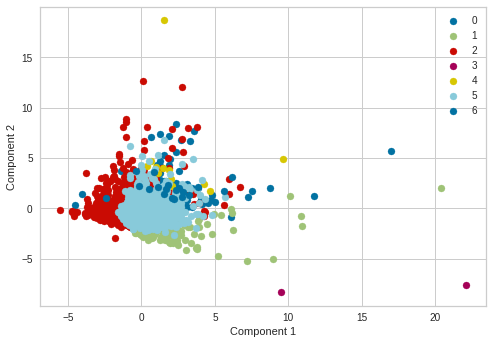

In [235]:
K=7
model = AgglomerativeClustering(n_clusters=K)
viewAggScatter(model)

In [236]:
t.head()

,koi_impact,koi_steff,koi_fpflag_nt,koi_insol,koi_kepmag,koi_srad,koi_prad,koi_duration,koi_fpflag_ec,dec,koi_depth,koi_model_snr,ra,koi_time0bk,koi_teq,koi_period,koi_slogg,koi_fpflag_ss,koi_fpflag_co
Class,,,,,,,,,,,,,,,,,,,
0,0.4055,4827.0,0.0,20.115,15.0925,0.7075,2.220,2.957750,0.0,44.141949,965.50,39.45,290.51648,151.401500,540.0,13.663717,4.6115,0.0,0.0
1,0.3480,5561.0,0.0,257.290,14.9520,0.9470,11.010,3.217900,0.0,45.439678,14231.00,1022.20,292.57986,154.235520,1021.0,3.855604,4.4600,0.0,0.0
2,0.7250,7606.0,0.0,31099.550,11.7025,2.6675,11.830,2.152685,0.0,44.545265,2325.80,2041.40,285.36763,126.183673,3372.5,1.228283,3.8360,0.5,0.0
3,0.2695,5778.5,0.0,53.105,14.6735,1.0965,8.995,4.579020,0.0,43.583460,6130.25,331.75,292.26730,170.051629,687.0,15.763352,4.3915,0.0,0.0
4,0.2535,5742.0,0.0,2391.165,14.1155,1.2470,1.450,1.935500,0.0,44.089634,152.55,25.40,290.92221,132.476340,1783.5,1.326078,4.2595,0.0,0.0


In [237]:
t.std()

koi_impact           0.171627
koi_steff          851.307964
koi_fpflag_nt        0.000000
koi_insol        11602.629156
koi_kepmag           1.201008
koi_srad             0.665939
koi_prad             4.968176
koi_duration         1.030777
koi_fpflag_ec        0.000000
dec                  1.084531
koi_depth         8534.025824
koi_model_snr      764.832882
ra                   2.535845
koi_time0bk         17.336046
koi_teq           1007.046028
koi_period           6.163230
koi_slogg            0.257706
koi_fpflag_ss        0.188982
koi_fpflag_co        0.000000
dtype: float64